In [16]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
sns.set_theme()

In [18]:
a = 20 # parameter a of the beta prior
b = 10 # parameter b of the beta prior
theta = 0.25 # true unknown parameter, P(HEAD)
n = 100 # number of coin tosses. Try 5000!

In [19]:
np.random.seed(42)
#y = np.random.binomial(n, theta) # random number of heads from the distribution from a binomial distribution
y = 24

# Practical lecture 1: Beta-Binomial, Gridding, Logarithmic tricks

Let us consider a coin that lands heads with probability $\theta=0.25$ (unknown to us). 

Our prior knowledge of $\theta$ is encoded in a Beta distribution (where "success" corresponds to the coin landing heads), with parameters $a=20$ and $b=10$:

$$ \theta \sim \rm{Beta}(a,b).$$

We toss the coin $n=100$ times and observe a number $y=24$ of heads. How does our belief of $\theta$ change with the measurement?

Note: If you need the Beta probability distribution $\rm Beta$ in Python, use `scipy.stats.beta`. If you need the beta function $B$ in Python, it is `scipy.special.beta`.

## 0: Probabilistic model

* Derive and comment the full probabilistic model.

The full probabilistic model is:

\begin{align}
\theta \sim \rm{Beta}(a,b)\\
y \mid \theta \sim \rm{Bin}(n, \theta).
\end{align}

More explicitly, the prior probability density function (pdf) of $\theta$ is:
\begin{align}
f_{\rm prior}(\theta) = \frac{1}{B(a, b)} \theta^{a-1} (1-\theta)^{b-1},\qquad \theta \in (0, 1),
\end{align}
and the probability mass function of $y$, conditioned on $\theta$, is:
$$
P(y \mid \theta) = {{n}\choose{y}} \theta^{y} (1-\theta)^{n-y}.
$$


It is the classic Beta-binomial model. The random variable $y$ represents the number of success (heads) events over $n$ trials. The success probability $\theta$ is constant in all flips, which are (conditionally) independent events. For a given value of $\theta$, the probability of observing $y$ heads in $n$ trials is a binomial. The prior of $\theta$ is a Beta with *fixed* coefficients $a$ and $b$.

The Beta prior distribution is *conjugate* with the binomial likelihood, and thus the posterior of $\theta$ has a close-form Beta structure.

## 1: Prior distribution


* Plot the probability density function (pdf) of the prior $f_{\rm prior}(\theta)$. Explain our prior belief on $\theta$ in words.

The prior distribution is:

$$ f_{\rm prior}(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1-\theta)^{b-1}, \qquad \theta \in (0, 1),$$

where $B(a,b)$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function) returning the right normalization constant such that $\int_{0}^1 f_{\rm prior}(\theta) \; d \theta = 1.$ <br/> 

In [20]:
def prior_pdf(theta, a=20, b=10):
    return 1/scipy.special.beta(a,b) * theta**(a-1) * (1-theta)**(b-1) 

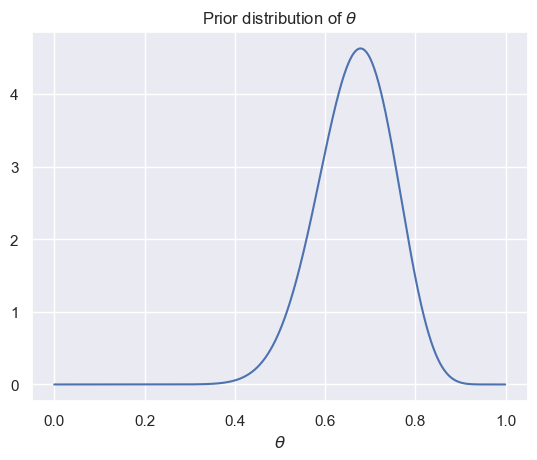

In [21]:
dtheta = 1e-3 # discretization step for theta
theta_vec = np.arange(0, 1, dtheta) # discretized theta range
plt.plot(theta_vec, prior_pdf(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Prior distribution of $\theta$");

In [22]:
prior_var = stats.beta(a, b) # prior random variable object
prior_var.rvs(2)

array([0.70370647, 0.67551564])

In [23]:
assert(np.allclose(prior_var.pdf(0.5) , prior_pdf(0.5))) # our implementation is close to the true value

* Compute the mean, the mode, and the standard deviation of the prior distribution

In [24]:
# See formulas in the lecture notes "The beta-binomial model"
prior_mean = a/(a+b)
prior_mode = (a-1)/(a + b - 2)
prior_sd = np.sqrt(a*b/((a+b)**2*(a+b+1)))
prior_mean, prior_mode, prior_sd

(0.6666666666666666, 0.6785714285714286, np.float64(0.08466675133346033))

* Plot the prior distribution together with its mean and mode, and comment the result. Is the prior representative of the true value of $\theta$?

## 2: Posterior distribution - exact derivation

* Obtain the posterior distribution in closed form.

The Beta-binomial model:
\begin{align}
\theta &\sim \mathrm{Beta}(a,b)\\
y \mid\theta &\sim \mathrm{Bin}(n, \theta)
\end{align}
is **conjugate**, meaning that the posterior distribution of $\theta$ given $y$ belongs to the same family as the prior.

It is well known that:
$$\theta \mid y \sim \mathrm{Beta}(a+y, b + n - y)$$
Which means:
$$f_{\rm post}(\theta) = f(\theta \mid y) = \frac{1}{B(a+y,b+n-y)} \theta^{a+y-1} (1-\theta)^{b+n-y-1}, \qquad \theta \in (0, 1).$$


The result can be derived from Bayes' rule:

\begin{equation*}
f(\theta \mid y) = \frac{P(y \mid \theta) f_{\rm prior}(\theta)}{P(y)} \propto \theta^{a+y-1} (1-\theta)^{b+n-y-1}.
\end{equation*}
Only a $\mathrm{Beta}$ random variable with parameters $a+y$ and $b+n-y$ has a pdf proportional to $\theta^{a+y-1} (1-\theta)^{b+n-y-1}$. The posterior is then a $\mathrm{Beta}(a+y, b + n - y)$.

In [25]:
a_post = a + y
b_post = b + n - y
post_var = stats.beta(a=a_post, b=b_post)

* Plot the posterior distribution together with the prior and the true value of $\theta$. Comment on the result.

## 3: Likelihood

* Compute the likelihood function $\mathcal{L}(\theta) = P(y \mid \theta)$ on a grid, for fixed $y$ equal to the measured number of heads and values of $\theta$ in the numerical range $[0, \,1]$. You may disregard the multiplicative factor that does not depend on $\theta$.

In [26]:
def lik(theta):
    return (theta ** y) * (1 - theta)**(n-y)

lik_vec = lik(theta_vec)

* Plot the likelihood function. What do you notice?

## 3. Point estimates

* Obtain the maximum likelihood (ML) point estimate $\theta^{\rm ml}$.

Hint: $\theta^{\rm ml}$ is the value of $\theta$ corresponding to the maximum of the likelihood function $\mathcal{L}(\theta)$:

$$\theta^{\rm ml} = \arg \max_{\theta} \mathcal{L}(\theta)$$

* Obtain the maximum a posteriori (MAP) point estimate $\theta^{\rm MAP}$.

Hint: $\theta^{\rm MAP}$ is the value of $\theta$ corresponding to the maximum of the posterior density $f_{\rm post }(\theta)$.

* Obtain the posterior mean point estimate $E[\theta \mid y]$<br/>
Hint: You can use close-form formulas for the mean of the Beta random variable.

## 4: Posterior distribution - gridding, aka brute-force approximation

* Obtain a numerical approximation of the posterior $f_{\rm post}(\theta)$, by normalizing the product $\mathcal{L}(\theta) \cdot f_{\rm prior}(\theta)$

By definition, the posterior distribution $f_{\rm post}(\theta)$ is:
$$f_{\rm post}(\theta) = f(\theta \mid  y) = \frac{\overbrace{P(y \mid \theta)}^{=\mathcal{L}(\theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$$
where $P(y) = \int{P(y \mid\theta)\; d\theta}$.

Thus, $f_{\rm post}(\theta)$ corresponds to the product $\mathcal{L}(\theta) \cdot f_{\rm prior}(\theta)$, up to a multiplicative constant to be determined.

We have:
$$f_{\rm post}(\theta) = \frac{1}{Z} \cdot \mathcal{L}(\theta) f_{\rm prior}(\theta),$$

where the normalization constant $Z$ must be chosen to satisfy:

$$\int_\theta f_{\rm post}(\theta) \; d\theta = 1,$$
thus

$$Z = \int_\theta \mathcal{L}(\theta) f_{\rm prior}(\theta) \; d\theta = 1.$$

Any numerical integration method can be used to approximate the integral above. Easiest choice: Riemann sum on a uniform grid, with step size $\Delta \theta$
$$ Z \approx \Delta \theta \sum_{i} \mathcal{L}(\theta_i) f_{\rm prior}(\theta_i)$$

In [27]:
p_theta_post = lik_vec * prior_var.pdf(theta_vec)
Z = (np.sum(p_theta_post) * dtheta)
p_theta_post = p_theta_post/Z

**NOTE**: The Beta-Binomial case is a very special and lucky (conjugate) combination where we can compute $f_{\rm post}(\theta)$ analytically. The gridding approach above is also applicable to non-conjugate prior/likelihood combinations. However, it is only feasible in 1-3 dimensions  (curse of dimensionality!). For non-conjugate prior/likelihood combinations in higher dimensions, more advanced methods are needed. See following lectures!

* Verify that the numerical approximation of the posterior is accurate

* Obtain a scaled version of the likelihood function $\mathcal{L}(\theta)$, such that $\int_{0}^{1} \mathcal{L}(\theta)\; d\theta = 1$. What does this function represent?

* Plot the posterior, the prior, and the scaled likelihood on the same axes. Comment the result.

* Try to execute the code above with a larger value of n (ex. n = 5000). What happens? Why?

## Enter the logarithm: log-likelihood and log-posterior

To avoid numerical difficulties, we may instead compute the *logarithm* of the likelihood and the posterior density. Starting from the definition:

$$f_{\rm post}(\theta) = f(\theta \mid y) = \frac{{P(y \mid \theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$$

we obtain the following formula for the log-posterior $g(\theta) = \log f_{\rm post}(\theta)$:
$$g(\theta) = \log f_{\rm post}(\theta) = \overbrace{\log P(y \mid \theta)}^{=\ell(\theta)} + \log f_{\rm prior}(\theta) + \log P(y)$$

Let us compute the *log-likelihood* $\ell(\theta)$:

$$\ell(\theta) = \log \mathcal{L}(\theta) = \log P(y \mid \theta) = 
\log {{n}\choose{y}} \theta^{y} (1-\theta)^{(n-y)}=\log{{n}\choose{y}} + y \log \theta + (n-y) \log (1-\theta)$$

* Evaluate and plot the log-likelihood $\ell(\theta)$ up to an additive constant over a grid

* Evaluate and plot the log-prior $\log f_{\rm prior}(\theta)$ up to an additive additive constant over a grid

* Evaluate and plot the log-posterior $g(\theta)$ up to an additive constant over a grid

* Obtain the normalized posterior $f(\theta \mid y)$ over a grid starting from the unnormalized log-posterior

### Alternative implementation using the logsumexp

In the previous implementation, we have first added the constant ``-np.max(log_post)`` to the log-posterior for numerical reasons. We then exponentiated and finally normalized the result so that it integrates to 1.

There is a "magic" normalization constant that help us achieve the same result even more easily, and it is based on the ``logsumexp`` function.

In [28]:
x = np.random.randn(100)
scipy.special.logsumexp(x)

np.float64(4.835708180330829)

In [29]:
np.sum(np.exp(x - scipy.special.logsumexp(x)))

np.float64(1.0000000000000004)

In [30]:
LSE = scipy.special.logsumexp(log_post_vec)
post_norm_ = 1/dtheta * np.exp(log_post_vec - LSE) # same as post_norm

NameError: name 'log_post_vec' is not defined

Mathematically, $\mathrm{logsumexp} : \mathbb{R}^{n} \mapsto \mathbb{R}$ is a *vector-to-scalar* function. For vector $\mathrm{x} = [x_0\; x_1\; \dots \; x_{n-1}]^\top \in \mathbb{R}^{n}$, it is defined by:

$$\mathrm{logsumexp}(\mathrm{x}) = \log \sum_{i=0}^{n-1} e^{x_i}.$$

Literally, it computes the log of the sum of the exponentiated elements of $x$

We have found the "magic constant" that provides a good scaling and the right normalization constant in one shot! How does it work?

Let us denote as $\tilde g(\theta)$ the log-posterior up to an additive constant $K$:

$$ \tilde g(\theta) = \log f_{\rm post}(\theta) + K \Rightarrow f_{\rm post}(\theta) = \frac{1}{Z} e^{\tilde g(\theta)}.$$

The constant $Z$ is such that $Z e^{\tilde g(\theta)}$ integrates to 1. Then,

$$ f_{\rm post}(\theta) = \frac{e^{\tilde g(\theta)}}{ \int{e^{\tilde g(\theta_i)}}\; d\theta}
\approx  \frac{e^{\tilde g(\theta)}}{\Delta \theta \sum_i{e^{\tilde g(\theta_i)}}} = 
\frac{e^{\tilde g(\theta)}}{\Delta \theta e^{\log \sum_i{e^{\tilde g(\theta_i)}}}} = \frac{1}{\Delta \theta} \frac{e^{\tilde g(\theta)}}{e^{\rm logsumexp(G)}} = \frac{1}{\Delta \theta}  e^{\tilde g(\theta) - \mathrm{logsumexp}(G)},$$
where $\mathrm{G} = [\tilde g(\theta_0), \tilde g(\theta_1), \dots, \tilde g(\theta_{n-1})]$ is the vector of the samples of $\tilde g$ at the grid points used for numerical integration of $\theta$.

## The logsumexp internals

* Internally, the logsumexp function avoid exponentiation with very small/very large numbers exploiting the identity:

$$ {\rm logsumexp}(x) = \log \sum_i e^{x_i} = c + \log \sum_i e^{(x_i - c)}.$$

* A robust implementation of logsumexp sets $c = \max(x_0, \dots, x_{n-1})$. This ensures that the largest exponentiated term is always $e^0=1$!


In [ ]:
def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

* Whenever we have a summation over the original probability/likelihood variables, we can alternatively perform a logsumexp operation over the corresponding the log-probability/log-likelihood variables. 

* Imagine we have a vector $x$ of log-probabilities and want to compute the sum of the probabilities. We have:
$$\sum_{i} e^{x_i}
% = \log e^{\overbrace{\log \sum_{i} e^{x_i}}^{= {\rm logsumexp}(x)}} 
= e^{{\rm logsumexp}(x)}.
%\log \left(\sum_{i} e^{x_i}\right) 
% = \log e^{\overbrace{\log \sum_{i} e^{x_i}}^{= {\rm logsumexp}(x)}} 
%= {{\rm logsumexp}(x)}.
$$

* If the probabilities $e^{x_i}$ are small (i.e., $x_i$ are negative values with a large modulus), direct evaluation of the left-hand side may fail and the logsumexp implementation at the right-hand side is to be preferred. 
    
* If we are interested in a result in the log-domain, the exponentiation at the right-hand side (which could also be problematic) is avoided.

* In general, it is suggested to perform as many operations as possible on log-variables and go back to probabilities/likelihoods only when it is strictly necessary (and numerically safe!)